# Time series Forecasting in Python & R, Part 1 (EDA)
> Time series forecasting using various forecasting methods in Python & R in one notebook. In the first, part I cover Exploratory Data Analysis (EDA) of the time series using visualizations and statistical methods.  

- toc: true 
- badges: true
- comments: true
- categories: [forecasting,R,Python,rpy2,altair]
- hide: false

## Project Goals

This is a quarterly sales data of a French retail company from Prof. Rob Hyndman's ["Forecasting Methods & Applications"](https://robjhyndman.com/forecasting/) book. I have uploaded the data to my [github](https://github.com/pawarbi/blog/tree/master/data). I chose this example because it's deceptively simple, easy to explain/demonstrate key concepts and Prof. Hyndman later applied the [state space approach](https://robjhyndman.com/expsmooth/) to this series using family of ETS models. The goals for this first part are:

1. Exploratory data analysis of the time series
2. Explain the time series behaviour in qualitative and quantitative terms to build intution for model selection
3. Identify the models that can be used based on the findings in the EDA

### Importing libraries


In [3]:
#collapse-hide
#Author: Sandeep Pawar
#Version: 1.0
#Date Mar 27, 2020

import pandas as pd
import numpy as np
import itertools

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
plt.style.use('seaborn-white')
%matplotlib inline

#statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
#from nimbusml.timeseries import SsaForecaster
from statsmodels.tsa.statespace.tools import diff as diff
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler


#library to use R in Python 
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
 


import warnings
warnings.filterwarnings("ignore")
np.random.seed(786)






>Note: I have found that results could be significanlty different if you use different versions of the libraries, especially with statsmodels. If you want to reproduce these results, be sure to use the same versions of these libraries. For this project, I created a conda virtual environment as rpy2 requires specific versions of Pandas & certain R libraries


In [4]:
#Printing library versions

print('Pandas:', pd.__version__)
print('Statsmodels:', sm.__version__)
print('Scipy:', scipy.__version__)
print('Rpy2:', rpy2.__version__)

Pandas: 0.25.0
Statsmodels: 0.11.0
Scipy: 1.4.1
Rpy2: 2.9.4


In [52]:
#collapse-hide
# Define some custom functions to help the analysis


def MAPE(y_true, y_pred): 
    """
    %Error compares true value with predicted value. Lower the better. Use this along with rmse(). If the series has 
    outliers, compare/select model using MAPE instead of rmse()
    
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
    
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
    
    Lags should be min(2*seasonal_period, T/5)
    
    from scipy.stats import anderson
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html
    anderson().statistic <0.05 => Normal distribution
    
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
    
    """
    resid_mean = np.mean(residuals)
    lj_p_val = min(ljung(x=residuals, lags=lags)[1])
    norm_p_val =  shapiro(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
    
    
    
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));

    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", resid_mean)
    
    print("\n** Ljung Box Test, p-value:", lj_p_val, "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
    
    print("\n** Shapiro Normality Test, p_value:", norm_p_val, "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
    
    print("\n** AD Fuller, p_value:", adfuller_p, "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    
    
    return ts_ax, acf_ax, kde_ax
    
def accuracy(y1,y2):
    
    accuracy_df=pd.DataFrame()
    
    rms_error = np.round(rmse(y1, y2),1)
    
    map_error = np.round(np.mean(np.abs((np.array(y1) - np.array(y2)) / np.array(y1))) * 100,1)
           
    accuracy_df=accuracy_df.append({"RMSE":rms_error, "%MAPE": map_error}, ignore_index=True)
    
    return accuracy_df

def plot_pgram(series,diff_order):
    """
    This function plots thd Power Spectral Density of a de-trended series. 
    PSD should also be calculated for a de-trended time series. Enter the order of differencing needed
    Output is a plot with PSD on Y and Time period on X axis
    
    Series: Pandas time series or np array
    differencing_order: int. Typically 1
    
    """
    #from scipy import signal    
    de_trended = series.diff(diff_order).dropna()
    f, fx = signal.periodogram(de_trended)
    freq=f.reshape(len(f),1) #reshape the array to a column
    psd = fx.reshape(len(f),1)
#     plt.figure(figsize=(5, 4)
    plt.plot(1/freq, psd  )
    plt.title("Periodogram")
    plt.xlabel("Time Period")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    



### Importing Data

In [4]:

path = 'https://raw.githubusercontent.com/pawarbi/datasets/master/timeseries/ts_frenchretail.csv'

#Sales numbers are in thousands, so I am dividing by 1000 to make it easier to work with numbers, especially squared errors
data = pd.read_csv(path, parse_dates=True, index_col="Date").div(1000)

data.index.freq='Q'

data.head()       


,Sales
Date,
2012-03-31,362.0
2012-06-30,385.0
2012-09-30,432.0
2012-12-31,341.0
2013-03-31,382.0


>Note: I have explicitly set the index frequency to *quarterly*. This makes  plotting and analyzing data with pandas and statsmodels easier. Many methods in Statsmodels have `freq` argument. Setting the frequency explicitly will pass the value automatically. More date offsets can be found in Pandas [documentation here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html). `freq='Q-DEC'` in the `index.freq` below shows quarterly data ending in December. Other advantage of setting the `.freq` value is that if the dates are not continous, Pandas will throw an error, which can be used to fix the data quality error and make the series continuos. Other common date offsets are:
 - Monthly Start: `'MS'`
 - Quarterly Start: `'QS'`
 - Weekly: `'W'`
 - Bi Weekly: `'2W'`
 - Business/ Weekday: `'B'`
 - Hourly: `'H'`
 

In [7]:
data.index

DatetimeIndex(['2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', freq='Q-DEC')

### Train Test Split:

Before analyzing the data, first split it into train and test (hold-out) for model evaluation. All the EDA and model fitting/selection should be done first using train data. Never look at the test sample until later to avoid any bias. Typically we want at least 3-4 full seasonal cycles for training, and test set length should be no less than the forecast horizon. 

In this example, we have 24 observations of the quarterly data, which means 6 full cycles (24/4). Our forecast horizon is 4 quarters. So training set should be more than 16 and less than 20. I will use first 18 observations for training and keep last 6 for validation.Note that I am always selecting the last 6 values for test by using `.iloc[:-6]`. As we get more data, this will ensure that last 6 values are always for validation. Unlike typical train/test split, we can not shuffle the data before splitting to retain the temporal structure.

#### Cross-validation:
Data  can be split using the above method or using cross-validation where the series is split into number of successive segments and the model is tested using one-step ahead forecast. Model accuracy in that case is based on the mean of the cross-validation errors over the number of splits used. This minimizes chances of overfitting. Be sure include at least 1-2 seasonal periods to capture the seasonality. e.g. in this case, the first training set of the CV should be min 8 values so the model has captured seasonal behaviour from 2 years. This is the preferred method when the time series is short. 

Our series has 24 obervations so I can use last 6-8 for validation. When this method is used, always check the sensisitivity of the model performance and model parameters to train/test size. If AIC or AICc is used for model evaluation, it approximatley approaches cross-validation error asymptotically.  


![](https://raw.githubusercontent.com/pawarbi/blog/master/images/train-test.png "Typical Train/Test Split vs. Cross-Validation")

In [53]:
#Split into train and test
train = data.iloc[:-6]
test  = data.iloc[-6:]
#forecast horizon
h = 6
train_length = len(train)

print('train_length:',train_length, '\n test_length:', len(test) )



train_length: 18 
 test_length: 6


In [60]:
train

,Sales
Date,
2012-03-31,362.0
2012-06-30,385.0
2012-09-30,432.0
2012-12-31,341.0
2013-03-31,382.0
2013-06-30,409.0
2013-09-30,498.0
2013-12-31,387.0
2014-03-31,473.0


## Exploratory Data Analysis & Modeling Implications

These are some of the questions I ask at various stages of model building. 


1. **Are there any null values? how many? best way to impute the null data?**
    - If null/NaNs are present, first identify why the data is missing and if NaNs mean anything. Missing values can be 
      filled by interpolation, forward-fill or backward-fill depending on the data and context. Also make sure null doesnt mean 0, which is acceptable but has modeling implications. 
    - It's important to understand how the data was generated (manual entry, ERP system), any transformations, assumptions were made before providing the data. 
      
      
2. **Are the data/dates continuous?**
    - In this exmaple I am only looking at continous time-series. There other methods that deal with non-continuous data. ETS & ARIMA require the data to be continuous. If the series is not continuous, we can add dummy data or use interpolation. 
    
    
3. **Are there any duplicate dates, data?**
    - Remove the duplicates or aggregate the data (e.g. average or mean) to treat duplicates
    
    
4. **Any 'potential' outliers?**
    - Outliers are defined as observations that differ significantly from the general observations. Identify if the data is 
      susceptible to outliers/spikes, if outliers mean anything and how to define outliers. While 'Outlier Detection' is a         topic in itself, in forecasting context we want to treat outliers before the data is used for fitting the model. Both 
      ETS and ARIMA class of models (especially ARIMA) are not robust to outliers and can provide erroneous forecasts. Data       should be analyzed while keeping seasonality in mind. e.g. a sudden spike could be because of the seasonal behaviour and not be outlier. Do not confuse outlier with 'influential data'.
      
    - Few ways to treat outliers:
        - Winsorization: Use Box and whiskers and clip the values tha exceed 1 & 99th percentile (not preferred)
        - Use residual standard deviation and compare against observed values (preferred but can't do *a priori*)
        - Use moving average to check spikes/troughs (iterative and not robust)
    
    - Another important reason to pay close attention to outliers is that we will choose the appropriate error metric based 
      on that. There are many error metrics used to assess accuracy of forecasts, *viz.* MAE, MSE, RMSE, %MAPE, %sMAPE. If 
      outliers are present, don't use RMSE because the squaring the error at the outlier value can inflate the RMSE. In that 
      case model should be selected/assessed using %MAPE or %sMAPE. More on that later. 
      
      
5. **Visually any trend, seasonality, cyclic behaviour?** 
     - This will help us choose the appropriate model (Single, Double, Triple Exponential Smoothing, ARIMA/SARIMA)
     - If cyclic behiour is present (seasonality is short-order variation e.g. month/quarter, cyclicity occurs over 10-20 
       years e.g. recession) we will need to use different type of decomposition (X11, STL). Depending on the context and 
       purpose of analysis, seasoanlity adjustment may also be needed.
     - If multiple seasonalities are present, ETS or ARIMA cannot be used. SSA, TBATS, harmonic regression are more 
       appropriate in that case. FB Prophet can also help with multiple seasonalities.
     - Frequency of seasonality is important. ETS & SARIMAX are not appropriate for high frequency data such as hourly, daily, sub-daily and even weekly. Consider using SSA,TBTAS, FB Prophet, deep learning models.
     
       
6. **How does the data change from season to season for each period and period to period and compared to the level?**
     - Does it increas/decrease with the trend? Changes slowly, rapidly or remains constant. This is an important 
       observation to be made, especially for ETS model, as it can determine the parametrs to be used & if any preprocessing 
       will be needed.
     - De-compose the series into level, trend, seasonal components and residual error. Observe the patterns in the decomposed series. 
     - Is the trend constant, growing/slowing linearly or exponentially or some other non-linear function?
     - Is the seasonal pattern repetitive?
     - How is the seasonal pattern changing relative to level? If it is constant relative to level, it shows "additive" seasonality, whereas if it is growing, it's "multiplicative"


7. **Distribution of the data? will we need any transformations?**
      - While normally distributed data is not a requirement for forecasting and doesnt necessarily improve point forecast accuracy, it can help stablize the variance and narrow the prediction interval. 
      - Plot the histogram/KDE for each time period (e.g. each year and each seasona) to get gauge peakedness, spread in the data. It can also help compare different periods and track trends over time.
      - If the data is severely skewed, consider normalizing the data before training the model. Be sure to apply inverse transformation on the forecasts. *Use the same transformation parameters on the train and test sets.* Stabilizing the variance by using Box Cox transformation (special case being log & inverse transform), power law etc can help more than normalizing the data.  
      - Watch out for outliers before transformation as it will affect the transformation
      - Plottng distribution also helps track "concept-drift" in the data, *i.e.* does the underlying temporal structure / assumption change over time. If the drift is significant, refit the model or at least re-evaluate. This can be tricky in time series analysis.
      - Uncertainty in the training data will lead to higher uncertainty in the forecast. If the data is highly volatile/uncertain (seen by spread in the distribution, standard deviation, non-constant variance etc), ETS and ARIMA models will not be suitable. Consider GARCH and other methods.
      
      
8. **Is the data stationary? Is this a white noise, random walk process?** 

      - Perhaps the most important concept to keep in mind when doing time series analysis and forecasting is that, time series is a *probabilistic / stochastic process*, and the time series we are analyzing is a *'realization of a stochastic process'*. A time signal could be deterministic or stochastic/probabilistic. In a deterministic process, the future values can be predicted exactly with a mathematical function e.g. y = sin(2$\pi$ft). In our case, the future values can only be expressed in terms of probability distribution. The point estimates are mean/median of the distribution. By definition, the mean has a distribution around it and as such the stakeholders should be made aware of the probabilistic nature of the forecast through uncertainty estimates.       
            
      - ***Stationarity***: Statistical stationarity means the time series has constant mean, variance and autocorrelation is insignificant at all lags. Autocorrelation is a mouthful, all it means is the correlation with its past self. e.g. to check if two variables are linearly correlated with each other, we calculate their coeff of correlation (Pearson correlation). Similarly,  *autocorrelation* does the same thing but with its past values (i.e lags). More on that later. For a stationary time series, the properties are the same no matter which part of the series (w.r.t time) we look at. This is a core concept of the ARIMA methods, as only stationary processes can be modeled using ARIMA. ETS can handle non-stationary processes. 
      - ***White Noise***: If a time series has zero mean and a constant variance , i.e. N(0,$\sigma^2$), it's a white noise. The variables in this case are *independent and identically distributed* (i.i.d) and are uncorrelated. We want the residuals left after fitting the model to be a white noise. White noise can be identified by using ADFuller test and plotting autocorrelation function (ACF) plots. In an ACF plot, the autocorrelation should be insignificant (inside the 95% CI band) at all lags. 
      - ***Random Walk***: Random walks are non-stationary. It's mean or variance or both change over time. Random walk cannot be forecast because we have more unknowns than the data so we will end up having way too many parameters in the model. In essence, random walk has no pattern to it, it's last data point plus some random signal (drift). Thus, if the first difference of the time series results in a white noise, it's an indication of a Random Walk. e.g. most equity stocks are random walk but by looking at percent difference (%growth over time) we can study the white noise.
                    `Next Data point = Previous Data Point + Random Noise`
                    `Random Noise = Next Data Point - Previous Data Point`
                    
    


![](https://raw.githubusercontent.com/pawarbi/blog/master/images/stationarity.png "Stationary vs. Non-Stationary process")


>Note: It's easy to mistake randomness for seasonality. In the random walk chart below, it can appear that the data has some seasonality but does not!

In [50]:
#collapse-hide

#create white noise with N(0,1.5), 500 points
np.random.seed(578)
steps = np.random.normal(0,1,500)

noise = pd.DataFrame({"x":steps})
wnoise_chart = alt.Chart(noise.reset_index()).mark_line().encode(
    x='index', 
    y='x').properties(
    title="White Noise")

#Create random walk with N(0,1.5), 500 points

steps[0]=0
rwalk = pd.DataFrame({"x":100 + np.cumsum(steps)}).reset_index()
rwalk_chart = alt.Chart(rwalk).mark_line().encode(
    x='index', 
    y=alt.Y('x', scale=alt.Scale(domain=(80,150)))).properties(
    title="Random Walk")


wnoise_chart | rwalk_chart



alt.HConcatChart(...)

9. **Auto-correlation? at what lag?** 
      - Study the second order properties (autocorrelation and power spectral density) of the time series along with mean, standard deviation, distribution. More details below. 
      
      
10. **If trend is present, momentum or mean-reversing?** 
      - Time series with momentum indicates the value tends to keep going up or down (relative to trend) depending on the immediate past. Series with mean-reversion indicates it will go up (or down) if it has gone down (or up) in the immediate past. This can be found by examining the coefficients of the ARIMA model. This provides more insight into the process and builds intuition. This doesnt not directly help with forecasting.
      
11. **Break-points in the series?**
      - Are there any structural breaks (shifts) in the series. Structural breaks are abrupt changes in the trend. Gather more information about the sudden changes. If the breaks are valid, ETS/ARIMA models wont work. FB Prophet, dynamic regression, deep learning models, adding more features might help. Identify the possible reasons for change, e.g. change in macros, price change, change in customer preferenaces etc. Note structural change persists for some time, while outliers do not. Break points are different from non-stationarity. Read more [here](http://faculty.baruch.cuny.edu/smanzan/FINMETRICS/_book/time-series-models.html#structural-breaks-in-time-series) for examples & explanations. In case of structural break-points, consider modeling the segments of the series separately.
      ![](https://raw.githubusercontent.com/pawarbi/blog/master/images/outlier-str%20brk-blog1.png "Outlier vs Structural Break")
      
      
12. **Intermittent demand?**
     - Time series is said to be intermittent when there are several 0 and small values (not nulls) in the series. ETS and ARIMA are not appropriate for this type of time series. It's a common pattern with inventory time series, especially for new items. Croston's method is one approach to use for forecasting intermittent demand. 
     - When demand is intermittent, use RMSE rather than %MAPE as the evaluation metric. With %MAPE, the denominator would be 0 leading to erroneous results. 


In [54]:
#collapse-hide
#creating intermittent demand plot
demand = [10, 12, 0, 3,50,0,0,18,0,4, 12,0,0,8,0,3]
demanddf = pd.DataFrame({'y': demand, 'x': np.arange(2000, 2016) } )
alt.Chart(demanddf).mark_bar().encode(
    x='x',
    y='y').properties(
    title="Example: Intermittent Demand", width = 700)

alt.Chart(...)


13. **Do we need any exogenous variables/external regressors?**
    - It may be necessary to include additional features/variables to accurately capture the time series behaviour. For example, the sales for a retailer might be higher on weekends, holidays, when it's warmer etc. This is different from seasonal pattern. In such cases, using the 'day of the week' or 'is_holiday' feature might provide better forecast. ETS models cannot use exogenous variable. SARIMAX (X is for exogenous), deep learning, XGB models are more suited.
    - Always inspect the residuals after fitting the model. If the residuals are correlated (use ACF/PACF plots, Ljung Box test on residuals), it's an indication that we are not capturing the time series behaviour accurately and could try adding exogenous behaviour. 
 

## EDA

### Data Integrity / Quality

In [62]:
#Any missing data?
print("missing_data:", train.isna().sum())
print("unique dates:", train.index.nunique())

missing_data: Sales    0
dtype: int64
unique dates: 18


In [64]:
#Counting number of values for each quarter and Year. Columsn are quarters.
#Here each qquarter and year has 1 value, thus no duplicates
pd.crosstab(index=train.index.year, columns=train.index.quarter)

col_0,1,2,3,4
row_0,,,,
2012,1,1,1,1
2013,1,1,1,1
2014,1,1,1,1
2015,1,1,1,1
2016,1,1,0,0


#### <font color=#4d6eae >Observations:</font>
1. No null values
2. Length of the train set is 18 and we have 12 unique dates/quarters so no duplicate dates
3. Each year and quarter has 1 observation, so no duplicates and data is continuous

### Time Series

Plotting the time series and the 4 quarter rolling mean using Altair. 

>Tip: Matplotlib and Seaborn create static charts, whereas plots created with Altair are interactive. You can hover over the data points to read tooltips. The most useful feature is the ability to zoom-in and out. Time series data can be dense and it's important to check each time period to get insights. With zoom-in/out, it can be done iteractively without slicing the time series. Altair's [documentation and example library](https://altair-viz.github.io/user_guide/interactions.html) is great. 

In [9]:
#collapse-hide
#Create line chart for Training data. index is reset to use Date column
train_chart=alt.Chart(train.reset_index()).mark_line(point=True).encode(
    x='Date', 
    y='Sales', 
    tooltip=['Date', 'Sales'])

#Create Rolling mean. This centered rolling mean 
rolling_mean = alt.Chart(train.reset_index()).mark_trail(
    color='orange',
    size=1
).transform_window(
    rolling_mean='mean(Sales)',
    frame=[-4,4]
).encode(
    x='Date:T',
    y='rolling_mean:Q',
    size='Sales'
)

#Add data labels
text = train_chart.mark_text(
    align='left',
    baseline='top',
    dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Sales:Q'
)

#Add zoom-in/out
scales = alt.selection_interval(bind='scales')

#Combine everything
(train_chart + rolling_mean +text).properties(
    width=600, 
    title="French Retail Sales & 4Q Rolling mean ( in '000)").add_selection(
    scales
)

alt.LayerChart(...)

#### Sub-series plot

Sub-series plot to show how the series behaves each year in all seasons (quarterly or monthly)

In [48]:
#collapse-hide
alt.Chart(train.reset_index()).mark_line(point=True).encode(
    x='quarter(Date)', 
    y='Sales',
    column='year(Date)',
    tooltip=['Date', 'Sales']).properties(
    title="Sales: Yearly Subseries plot",
    width=100).configure_header(
    titleColor='black',
    titleFontSize=14,
    labelColor='blue',
    labelFontSize=14
)

alt.Chart(...)

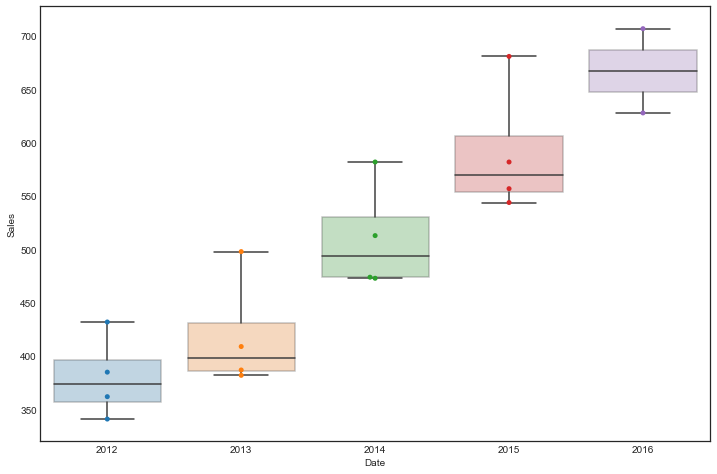

In [30]:
#box plot to see distribution of sales in each year
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(data=train, x=train.index.year, y = 'Sales',  ax = ax, boxprops=dict(alpha=.3));
sns.swarmplot(data=train, x=train.index.year, y = 'Sales');

In [57]:
#%Growth each year. Excluding 2016 since we have only 2 quarters
growth = train[:'2015'].groupby(train[:'2015'].index.year)["Sales"].sum().pct_change()
growth

Date
2012         NaN
2013    0.102632
2014    0.218377
2015    0.157689
Name: Sales, dtype: float64

####  Observations:
1. Sales has gone up each year from 2012-2015 =>Positive Trend present. 
2. Typically, Sales goes up from Q1 to Q3, peaks in Q3, drops in Q4. Definitely a seasoanl pattern. => Model should capture seasonality and trend.
2. Just comparing Q4 peaks, sales has gone up from \\$432K to \\$582K => Trend exists, Model should capture trend. No cyclic behaviour 
3. Overall data looks clean, no observations outside of IQR => Clean data, no outliers
4. No structural breaks, intermittent pattern => ETS and SARIMA may be used
5. Notice that the length of the bar in box plot increases from 2012-2015. => Mean & variance increasing, we will need to stabilize the variance by taking log or using Box Cox transform


### Quarterly trends & distrbution

Quarterly sub-series plot to see how the series behaves in each quarter across alll years. 

In [72]:
#collapse-hide
alt.Chart(train.reset_index()).mark_line(point=True).encode(
    x='year(Date)', 
    y='Sales',
    column='quarter(Date)',
    tooltip=['Date', 'Sales']).properties(
    title="Sales: Quarterly Subseries plot",
    width=100).configure_header(
    titleColor='black',
    titleFontSize=14,
    labelColor='blue',
    labelFontSize=14
)

alt.Chart(...)

>Tip: Statsmodels has a `quarter_plot()` method that can be used to create similar chart easily. 

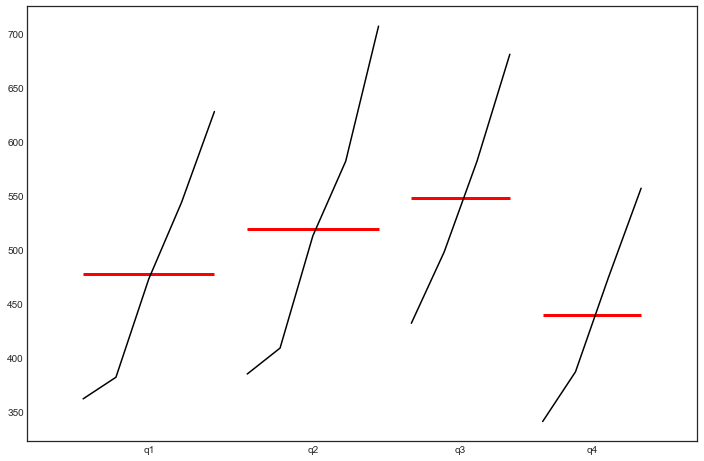

In [47]:
#Quarterly plot: Shows trend for Q1-Q4 for each of the years. Red line shows mean
quarter_plot(train);

##### Distribution of Sales in each year

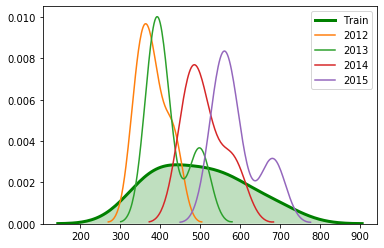

In [65]:
#collapse-hide
#Distribution plot of each year compared with overall distribution
sns.distplot(train,         label='Train', hist=False, kde_kws={"color": "g", "lw": 3, "label": "Train","shade":True})
sns.distplot(train['2012'], label='2012', hist=False)
sns.distplot(train['2013'], label='2013', hist=False)
sns.distplot(train['2014'], label='2014', hist=False)
sns.distplot(train['2015'], label='2015', hist=False);



In this case the heatmap feels redundant but when the series is long, heatmap can reveal more patterns

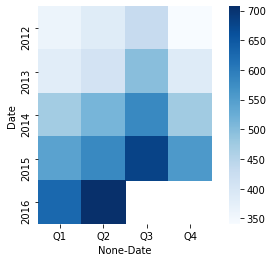

In [66]:
#collapse-hide
sns.heatmap(pd.pivot_table(data=train, index=train.index.year, columns=train.index.quarter),
           square=True,
           cmap='Blues',
           xticklabels=["Q1", "Q2", "Q3", "Q4"]);

Visualizing the quarterly sales for each year as %

In [6]:
#collapse-hide
#As stacked bar chart, in % values. 
stack1= alt.Chart(train[:'2015'].reset_index()).mark_bar().encode(
    x=alt.X('sum(Sales)'),
    y='year(Date):N',
    color=alt.Color(
        'quarter(Date)',
        scale=alt.Scale(scheme='category10')),
    tooltip=["Date", "Sales"]).properties(
    height=100, 
    width = 300, 
    title = "Sum of Sales by each Quarter")
    
stack2= alt.Chart(train[:'2015'].reset_index()).mark_bar().encode(
    x=alt.X('sum(Sales)', stack='normalize'),
    y='year(Date):N',
    color=alt.Color(
        'quarter(Date)', 
        scale=alt.Scale(scheme='category10')),
    tooltip=["Date", "Sales"]
    ).properties(
    height=100, 
    width = 300, 
    title = "Sum of Sales as % by each Quarter")



stack1 | stack2

alt.HConcatChart(...)

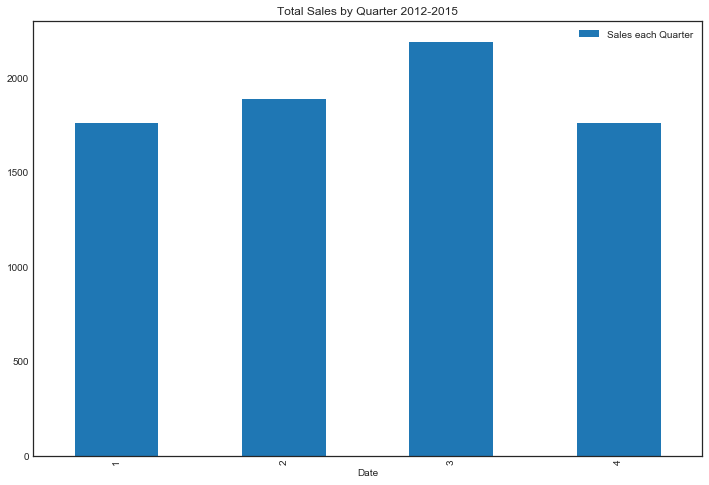

In [49]:
pie= train[:'2015'].groupby(train[:'2015'].index.quarter)["Sales"].sum().plot.bar(
    title="Total Sales by Quarter 2012-2015", legend=True, label="Sales each Quarter")

####  Observations:
1. Quarter plot & heatmap confirm peak in Q3, drop in Q4. 
2. For each of the years the upward trend observed in all quarters
3. Kenel Density plot shows data looks normally distributed, bi-modal distribution in quarters is because of small sample size. Peaks shift right from 2012 to 2015 indicating increase in average. 
4. Distribution becomes fatter as the years progress, indicating higher spread/variation (as seen above in boxplot too)
5. Though The sales peak in Q3 each year, as a % of annual sales, all quarters contribute roughly the same

### Decomposition

We will de-compose the time series into trend, seasonal and residuals

>Tip: *Always* use a semicolon (;) after plotting any results from statsmodels. For some reason if you don't, it will print the plots twice. Also, by default the statsmodels plots are small and do not have a `figsize()` argument. Use `rcParams()` to define the plot size

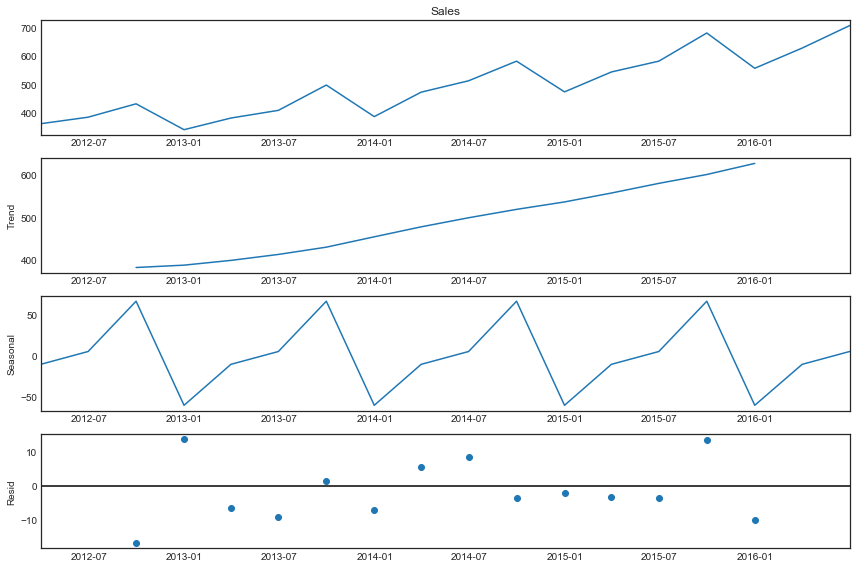

In [21]:
decompose = seasonal_decompose(train["Sales"])
decompose.plot();
plt.rcParams['figure.figsize'] = (12, 8)

#### Observations:

1. Trend is more than linear, notice a small upward take off after 2013-07. Also notice that trend is projecting upward and does not seem to be dampening/leveling off.
2. Seasonal pattern is consistent
3. Resduals are whetever is left after fitting the trend and seasonal components to the observed data. It's the component we cannot explain. We want the residuals to be i.i.d (i.e uncorrelated). If the residuals have a pattern, it means there still some structural information left to be captured. Residuals are showing some wavy pattern, which is not good. Let's perform Ljung Box test to confirm if they are *i.i.d as a group*.
4. We do not want to see any recognizable patterns in the residuals, e.g. waves, upward/downward slope, funnel pattern etc. 


In [45]:
ljung_p = min(ljung(x=decompose.resid.dropna())[1]).round(3)
print("Ljung Box, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box, p value: 0.072 , Residuals are uncorrelated


Residuals are uncorrelated. If the residuals are correlated, we can perform transformations to see if it stabilizes the variance. It's also an indication that we may need to use exogenous variable to fully explain the time series behaviour.

### Second Order Properties of the time series

We study the second order properties to understand - 
 - is the data stationary
 - is the data white noise, random walk? i.e are the lags correlated?
 - quantify seasonal/cyclic behviour
 


#### Stationarity:
For the series to be stationary, it must have:
 - constant mean
 - constant variance
 - constant covariance (uncorrelated)

We verify this by observing change in mean, variance, autocorrelation and with a statistical test (ADFuller test)

##### Is the mean constant?

Mean is: 496.5


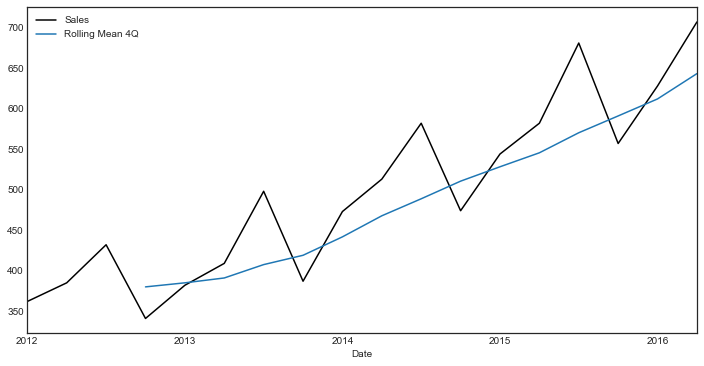

In [27]:
train.plot(figsize=(12,6), legend=True, label="Train", cmap='gray')
train["Sales"].rolling(4, center=False).mean().plot(legend=True, label="Rolling Mean 4Q");
print("Mean is:", train["Sales"].mean())

Notice that each year, the difference between the mean and the max in Q3 increases. This can potentially mean multiplicative seasonality.

##### Is the variance constant?

S.D is: 110.9


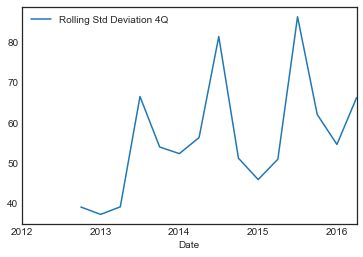

In [29]:
train["Sales"].rolling(4).std().plot(legend=True, label="Rolling Std Deviation 4Q");
print("S.D is:", train["Sales"].std().round(1))

Both mean and standard deviation are increasing, thus not stationary. 

#### Coefficient of Variation:
Coefficient of variation gives us an idea about the variability in the process, especially when looking at sales and demand. NOte that this should be used for relative comparison and does not have a strict statistical defition. It's very common measure in demand planning and inventory analytics. 

c.v = s.d/mean

If C.V<0.75     => Low Variability

If 0.75<C.V<1.3 => Medium Variability

If C.V>1.3      => High Variability



In [8]:
cv = train["Sales"].std()/train["Sales"].mean()
cv

0.22339170922484414

This is a low-variability process. 

##### Is the covariance constant?


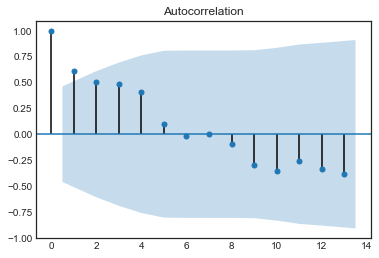

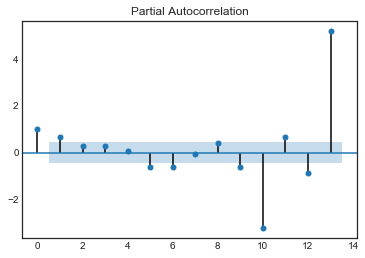

In [111]:
#Plot ACF and PACF using statsmodels
plot_acf(train);
plot_pacf(train);

*ADFuller Test for stationarity*

Augmented Dicky Fuller test is a statistical test for stionarity. If the p value is less than 0.05, the series is stationary, otherwise non-stationary. Use `adfuller()` class from statsmodels 

In [69]:
#Calculate ad fuller statistic
adf = adfuller(train["Sales"])[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.9990329594016152 , Series is Non-Stationary


#### Observations:
1. ACF: ACF plot shows autocorrelation coeff is insignificant at all lag values (within the blue 95%CI band), except lag 1. When studying ACF plots, we look at these 4 things
    - *Are any lags significant*, i.e outside the blue band of 95% CI. If they are, the series is correlated with itself at those lags. Note there is 5% chance that the lag shown as insignificant (ACF=0) is shows as  significant. In our case, 1st lag is barely significant, indicating sales last quarter affect the sales this quarter. 
    - *How quickly do the bar lenghts change*: If the bars are taping down, that shows presence of trend. Our series has a trend
    - *Pattern*: If the ACF shows up/down repeating pattern, it means seasonality with size equal to length of repetition. 
    - *Sign of ACF*: Alternating signs in ACF shows mean-reversing process whereas if all the ACs are positive (or negative), it shows momentum process. 

Properties of ACF help us determine the order of the MA process. More on that in future blog. 

2. ADFuller test shows that the series is not stationary. We can try to make it stationary by differencing it.

p value:1.5447008482407146e-18 , Series is Stationary


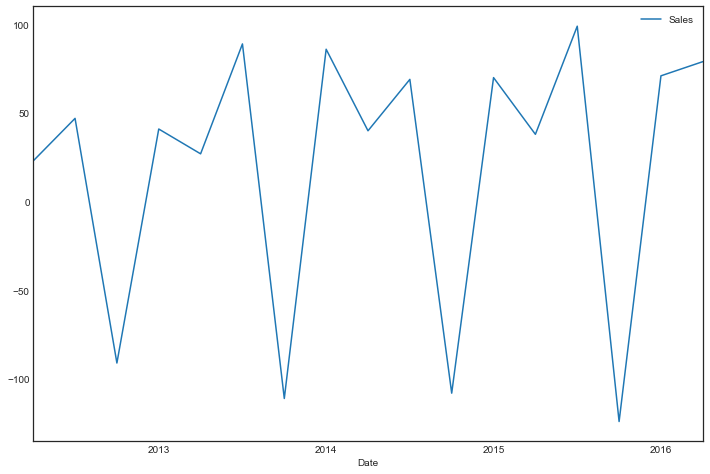

In [55]:
#De-trending
de_trended = train.diff(1).dropna()
adf2 = adfuller(de_trended)[1]
print(f"p value:{adf2}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")
de_trended.plot();


By taking the first difference we de-trended the series and it has become stationary!

*Autocovariance function* vs *autocorrelation fucntion*
The autocovariance measures the linear dependence between two points on the same series observed at different times. Very smooth series exhibit autocovariance functions that stay large even when the t and s are far apart, whereas choppy series tend to have autocovariance functions that are nearly zero for large separations. autocorrelation functions (ACF) measures the predictability (linear), and is the normalized autocovariance. ACF, just like a correlation coeff, is between [-1,1] and is easier to interprete. Both measure linear dependence between random variables. 

For example, the scatterplot below shows the train["Sales"] plotted against it's first lag. We can see a linear, although weak, relationship between them. Use `pandas.plotting.lag_plot()` 

*Lag plot, 1st lag*

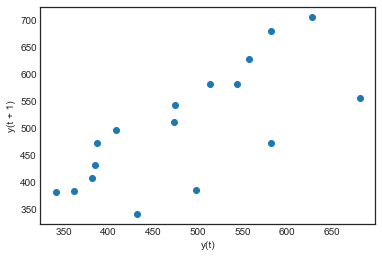

In [24]:
pd.plotting.lag_plot(train["Sales"],1);

*Lag plot, 2nd lag* : Weak relationship 

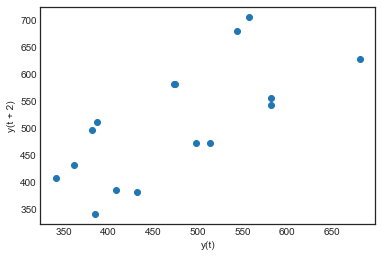

In [9]:
pd.plotting.lag_plot(train["Sales"],2);

>Note: If you wish to study the lags, you can obtain it by `.shift()` method.

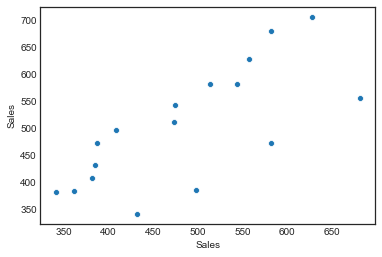

In [21]:
sns.scatterplot(train["Sales"], train["Sales"].shift(-1));

>Important: Use statsmodels for calculating ACF and NOT pandas `pd.Series.autocorr()`

Statsmodels and R use mean differencing, i.e subtract the mean of the *entire* series before summing it up, whereas Pandas uses Pearson correlation to calculate the ACF. Pearson correlation uses mean of the *subseries* rather than the entire series. For a long time series, the difference between the two should be negligible but for a short series, the diffrenece could be significant. In most cases, we are more interested in the pattern in the ACF than the actual values so, in a practical sense either would work. But, to be consistent and accurate use statsmodels to calculate and plot the ACF.


##### Which frequencies are prominent?

We typically look at the time series in the time domain. But, we can also analyze the time series in the frequency domain. It's based on the assumption that it is made up of sine and cosine waves of different frequencies. This helps us detect periodic component of known/unknown frequencies. It can show additional details of the time series that can be easily missed. We do it with a *Periodogram* and *Power Spectral Density* plot. 

*Periodogram*: We analyze frequency and associated intensity of frequency. Note that below I have invrted the frequency to obtain periods `Period,T = 1/frequency`. For example, a monthly time series has 12 seasonal periods, so we would obtain frequency = 1/12 = 0.0833. In our example, we expect to see the intensity to be high at period=4  

>Tip: Periodogram should be plotted for a de-trended time series. Time series can be obtained by differencing the series  

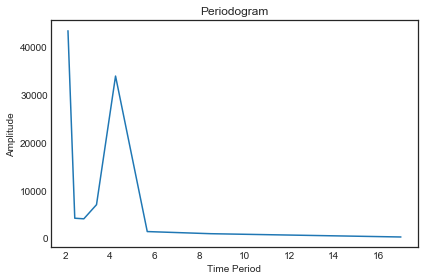

In [65]:
plot_pgram(train["Sales"],1);

*Power Spectral Density*: Periodogram assumes the frequencies to be harmonics of the fundamental frequency, whereas PSD allows the frequency to vary contunuously. PSD is calculated using autocovariance function (ACF seen above). Spectral density is the amount of variance per frequency interval. PSD shows the eaxct same information of the time series as the ACF, just in the frequency domain. We rarely use PSD for business time series analysis. Plot below shows that lower frequency content dominates the time series. If it had another bump at higher frequency, that would indicate cyclic behaviour. Sometime it can be easier to figure out MA vs AR process by looking at the PSD plot.    

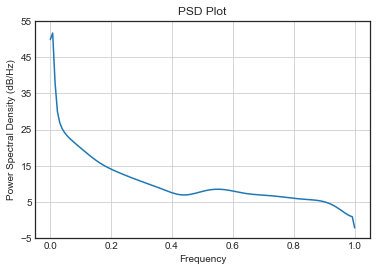

In [67]:
#Plot PSD
plt.psd(train["Sales"], detrend='linear');
plt.title("PSD Plot");

#### Is the series Normal?

As mentioned above, series does not have to be Gaussian for accurate forecasting but if the data is highly skewed it can affect the model selection and forecast uncertainty. In general, if the series is non-gaussian, it should be normalized before any further transformations (differencing, log, Box Cox) at least to check if normalization helps. Normalization will also help if decide to use regression, tree-based models, NN models later. Note that with normalization, we make the z score between [0,1], with *standardization* on the other hand , we center the distribution with mean =0, s.d.=1.  

Normality can be checked visually by plotting the density plot, q-q plot and Shapiro-Wilk test.

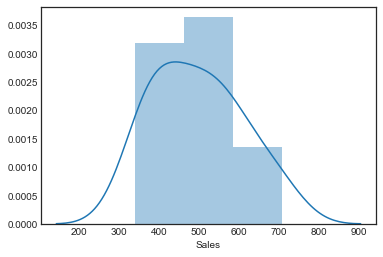

In [22]:
#Distribution Plot
sns.distplot(train["Sales"]);

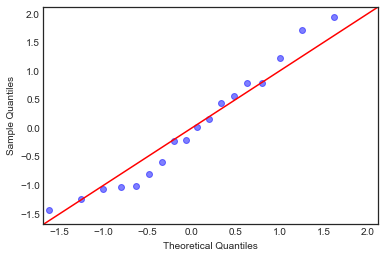

In [75]:
#Q-Q Plot
sm.qqplot(train["Sales"], fit=True, line='45', alpha=0.5, dist='norm' );

In [63]:
#Stastical Test
is_norm=shapiro(train["Sales"])[1]
print(f"p value:{is_norm}", ", Series is Normal" if is_norm >0.05 else ", Series is Non-Normal")


p value:0.4259689450263977 , Series is Normal


#### <font color=#4d6eae >Observations:</font>
1. Q-Q plot shows the data follows the 45deg line very closely, deviates slightly in the left tail. 
2. Shapiro-Wilk test shows the data is from Normal distribution

## Summary

Here is a summary of what we have learned about this time series:
1. There are no null values, outliers or duplicate values in the series. Series is continuous, non-intermittent. No structural breaks. We don't have to do any cleaning.
2. Series has a trend. Sales have increased every year. It looks more than linear but less than exponential. We might need to try Box Cox transform. 
3. Series has seasonality with seasonal periods = 4. Peak in Q3, drops in Q4, ramps up from Q1 to Q3. No other dominant periods. No cyclic behaviour.
4. Avg sales per quarter is 497, and S.D is 111, low variability. We will use this to guage the model error relative to mean and S.D. 
5. Since it is not a high-frequency data and has fixed seasonality, we can use ETS class of models
6. SARIMA could be used. We will need at least 1 differencing as de-trended series was stationary
7. Mean, variance, covariance are not constant. Series is not stationary, not white noise and not random-walk.
8. Variance increasing with time. Highs also look to be increasing relative to mean (rolling avg). 'multiplicative' seasonality might fit better in ETS model
9. Series is not normal but did not look highly skewed 
10. 1st lag was significant, though barely (ACF~0.5)
11. We do not have any information on exogenous variables
12. As there are no outliers and series is not intermittent, we can use RSME for model evaluation
13. We never looked at the test data. All the EDA and model building must be done using the training set. Intuitively, given what we have observed in the training set, we expect the forecast to be on the upward trend with slightly mupltiplicative seasonality. Trend does not seems to ve leveling off.


Model explainability is as important as model accuracy. We will keep above insights in mind when choosing, fitting, evaluating and selecting the model. We will choose the model that we can explain based on above insights. It is important to be able to explain the time series behavour in qualitative and quantitative terms.

Part 2: ETS Model
Part 3: ARIMA Model 
Part 4: FB Prophet
Part 5: Selecting the best model 


## Using R for time series EDA

[Forecasting Principles and Practice](https://otexts.com/fpp2/) by Prof. Hyndmand and Prof. Athanasapoulos is the best and most practical book on time series analysis. Most of the concepts discussed in this blog are from this book. Below is code to run the `forecast()` and `fpp2()` libraries in Python notebook using rpy2

In [57]:
import rpy2

import warnings
warnings.filterwarnings('ignore')

from rpy2.robjects import pandas2ri
import rpy2.rinterface as rinterface
pandas2ri.activate()

%load_ext rpy2.ipython

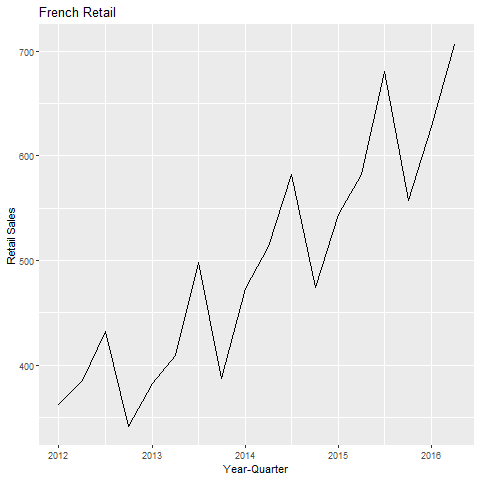

In [60]:
%%R -i data,train -o r_train

library(fpp2)

r_train <- ts(train$Sales, start=c(2012,01), frequency=4)
r_train %>%  autoplot() + ggtitle("French Retail") +xlab("Year-Quarter")+ylab("Retail Sales")


In [42]:
%Rpush r_train

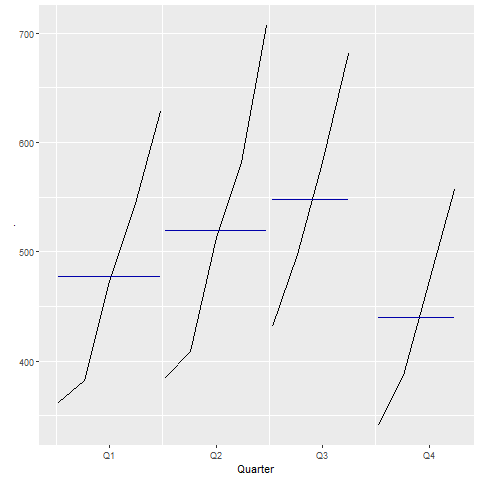

In [61]:
%%R -i r_train

r_train %>% ggsubseriesplot()

##### Lag Plots

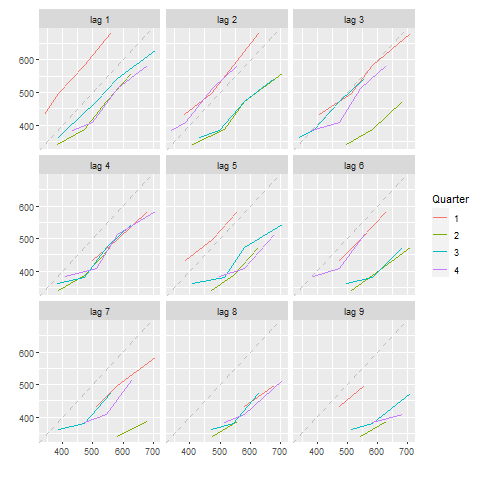

In [49]:
%%R 

r_train %>% gglagplot()

##### ACF Plots

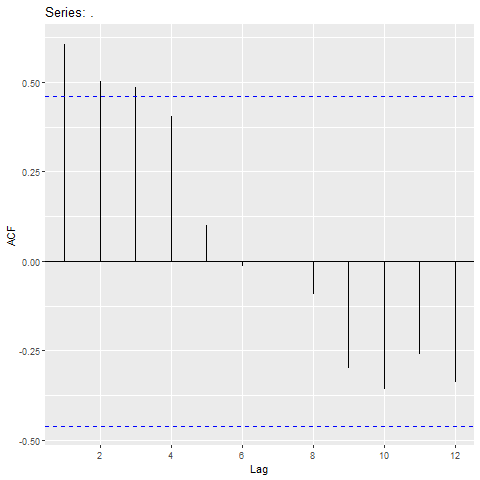

In [50]:
%%R 

r_train %>% ggAcf()

R shows 3 lags to be significant, whereas in Python we saw only the first lag to be significant. I am not sure why. 
Just to confirm, I am did the analysis in JMP statistical software. Below are the results. It matches with Python's results - 1st lag to be significant, spectral density plot matches too. 

![](https://raw.githubusercontent.com/pawarbi/blog/master/images/french_retail_blog1_jmp_ts.PNG "EDA in JMP, it shows on only the first lag to be significant")

##### Outlier detection

In [56]:
%%R -o olier
olier <- r_train %>% tsoutliers()

In [57]:
print(olier, end="")

$index

integer(0)



$replacements

numeric(0)




using `tsoutliers()` does not return any results, showing there are no statistical outliers

### References:
   1. Forecasting: Principles and Practice, by Prof. Hyndman
   2. Time Series Analysis and its Applications, by Robert Shumway
   3. Time Series Analysis and Forecasting, by Montgomery  & Jennings
   4. Introduction to Time Series and Analysis, by Brockwell